In [1]:
import numpy as np
from scipy.stats import entropy

class ReinforcementEnvironment:
    def __init__(self, num_bands, energy_cost=2, reward_factor=5, weight=5, max_timestep=180):
        self.num_bands = num_bands
        self.energy_cost = energy_cost
        self.reward_factor = reward_factor
        self.max_timestep = max_timestep
        self.weight = weight
        self.signal_band = {band: [] for band in range(self.num_bands)}
        self.current_timestep = 0
        self.transition_matrixes = {band: {} for band in range(self.num_bands)}
        self.init_bands()
        self.current_state = self.get_current_state()
    
    def init_bands(self):
        """Initialize each band with two initial signal values (0 or 1)"""
        for band in range(self.num_bands):
            # First signal chosen with equal probability
            t1 = np.random.choice([0, 1])
            
            # Second signal chosen with random probability distribution
            t_m1 = np.random.rand(2,2)
            t_m1 /= t_m1.sum(axis=1,keepdims=True)  # Normalize to create valid probability distribution
            t2 = np.random.choice([0, 1], p=t_m1[t1])
            # t_m2 = {
            #     (0, 0): np.random.rand(2),
            #     (0, 1): np.random.rand(2),
            #     (1, 0): np.random.rand(2),
            #     (1, 1): np.random.rand(2)
            # }
            # for k in t_m2:
            #     t_m2[k] /= t_m2[k].sum()
            t_m2 = {
            (0, 0): np.random.dirichlet([1, 1]),  # Generates a valid probability distribution over {0,1}
            (0, 1): np.random.dirichlet([1, 1]),
            (1, 0): np.random.dirichlet([1, 1]),
            (1, 1): np.random.dirichlet([1, 1])
            }
            self.transition_matrixes[band] = t_m2
            self.signal_band[band] = [t1, t2]  
    
    def step(self, action):
        """
        Execute one time step within the environment
        
        Args:
            action: tuple (band, prediction) where band is the selected frequency band
                   and prediction is the predicted signal value (0 or 1)
        
        Returns:
            tuple: (observation, reward, done, info)
        """
        self.current_timestep += 1
        
        band = action[0]
        prediction = action[1]
        
        reward = self._calculate_reward(self.current_state[band], prediction)
        
        self.generate_state()
        
        observation = self.construct_observation_space()
        
        done = self.current_timestep >= self.max_timestep
        
        info = {
            "timestep": self.current_timestep,
            "correct_prediction": self.current_state[band] == prediction,
            "state": self.current_state
        }
        
        return observation, reward, done, info
    
    def _calculate_reward(self, actual_signal, prediction):
        """Calculate reward based on prediction accuracy and signal value"""
        if actual_signal == prediction:
            # Correct prediction
            reward = self.reward_factor * self.weight - self.energy_cost
        elif actual_signal == 0:
            # Incorrect prediction when signal is 0
            reward = self.reward_factor - self.energy_cost
        else:  # actual_signal == 1
            # Incorrect prediction when signal is 1
            reward = self.reward_factor - self.energy_cost * self.weight
        
        return reward
    
    def generate_state(self):
        """Generate next state for all bands based on transition probabilities"""
        for band in range(self.num_bands):
            # Get last two signals for this band
            p_2 = tuple(self.signal_band[band][-2:])
            
            t_m2 = self.transition_matrixes[band]
            
            next_signal = np.random.choice([0, 1], p=t_m2[p_2])
            
            self.signal_band[band].append(next_signal)
            self.signal_band[band].pop(0)
        
        # Update current state
        self.current_state = self.get_current_state()
        
        return self.current_state
    
    def get_current_state(self):
        """Return the current state as a list of the most recent signal for each band"""
        return [self.signal_band[band][-1] for band in range(self.num_bands)]
    
    def reset(self):
        """Reset the environment to initial state and return initial observation"""
        self.signal_band = {band: [] for band in range(self.num_bands)}
        self.current_timestep = 0
        self.init_bands()
        self.current_state = self.get_current_state()
        return self.construct_observation_space()
    
    def construct_observation_space(self, window_size=10):
        """
        Construct observation space with entropy calculations for each band
        
        Args:
            window_size: Number of recent signals to consider for entropy calculation
            
        Returns:
            list: Entropy values for each band
        """
        observation = []
        for band in range(self.num_bands):
            signal_values = np.array(self.signal_band[band][-window_size:])
            
            if len(signal_values) <= window_size:
                entropy_value = 0
            else:
                value_counts = np.bincount(signal_values, minlength=2)
                
                probability_distribution = value_counts / len(signal_values)
                
                # Handle edge cases
                if np.all(probability_distribution == 0):
                    entropy_value = 0
                else:
                    # Calculate entropy using scipy function
                    entropy_value = entropy(probability_distribution, base=2)
            
            observation.append(entropy_value)
        
        return observation
    
    def soft_reset(self):
        self.signal_band = {band: self.signal_band[band][-2:] for band in range(self.num_bands)}
        self.current_timestep = 0
        self.generate_state()
        return self.construct_observation_space()
        

In [2]:
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import random
from collections import deque
import matplotlib.pyplot as plt
import numpy as np

class AdvancedDeepQNetwork(nn.Module):
    def __init__(self, input_dim, output_dim):
        """
        Enhanced Deep Q-Network with simplified architecture
        
        Args:
            input_dim (int): Dimension of input observation space
            output_dim (int): Number of possible actions
        """
        super(AdvancedDeepQNetwork, self).__init__()
        # Simplified network architecture
        self.fc1 = nn.Linear(input_dim, 128)
        self.fc2 = nn.Linear(128, 256)
        self.fc3 = nn.Linear(256, 128)
        self.fc_out = nn.Linear(128, output_dim)
        
        # Dropout for regularization
        self.dropout = nn.Dropout(0.2)
    
    def forward(self, x):
        # Ensure input is float tensor and has correct shape
        x = x.float()
        
        # Ensure input is at least 2D
        if x.dim() == 1:
            x = x.unsqueeze(0)
        
        # First layer with ReLU and dropout
        x = F.relu(self.fc1(x))
        x = self.dropout(x)
        
        # Second layer with ReLU and dropout
        x = F.relu(self.fc2(x))
        x = self.dropout(x)
        
        # Third layer with ReLU
        x = F.relu(self.fc3(x))
        
        # Output layer
        return self.fc_out(x)

class ImprovedDQNAgent:
    def __init__(self, env, input_dim, output_dim):
        """
        Enhanced Deep Q-Learning Agent with softmax exploration
        """
        self.env = env
        self.input_dim = input_dim
        self.output_dim = output_dim
        
        self.device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
        
        # Advanced network with twin networks
        self.q_network = AdvancedDeepQNetwork(input_dim, output_dim).to(self.device)
        self.target_network = AdvancedDeepQNetwork(input_dim, output_dim).to(self.device)
        self.target_network.load_state_dict(self.q_network.state_dict())
        
        # More sophisticated hyperparameters
        self.learning_rate = 0.0005  # Reduced learning rate
        self.gamma = 0.99  # Discount factor
        
        # Softmax exploration parameters
        self.temperature = 1.0
        self.min_temperature = 0.1
        self.temperature_decay = 0.9995  # Gradual temperature reduction
        self.temperature_decay_steps = 500  # Decay over 500 episodes
        
        # Prioritized Experience Replay
        self.replay_memory = []
        self.memory_size = 20000
        self.batch_size = 128  # Increased batch size
        
        # Optimizer with adaptive learning rate
        self.optimizer = optim.Adam(
            self.q_network.parameters(), 
            lr=self.learning_rate, 
            weight_decay=1e-5  # L2 regularization
        )
        
        # Loss function with huber loss for more robust learning
        self.loss_fn = F.smooth_l1_loss
    
    def select_action(self, state):
        """
        Softmax action selection strategy:
        - Uses temperature-based softmax exploration
        - Dynamically adjusts exploration temperature
        - Converts Q-values to action probabilities
        """
        # Decay temperature over episodes
        self.temperature = max(
            self.min_temperature, 
            self.temperature * (self.temperature_decay ** (1 / self.temperature_decay_steps))
        )
        
        with torch.no_grad():
            # Prepare state tensor
            state_tensor = torch.tensor(state, dtype=torch.float32).to(self.device).unsqueeze(0)
            
            # Get Q-values from the network
            q_values = self.q_network(state_tensor).squeeze(0).cpu().numpy()
            
            # Compute softmax probabilities with temperature scaling
            # Subtract max for numerical stability
            scaled_q_values = q_values / self.temperature
            scaled_q_values -= np.max(scaled_q_values)
            
            # Compute softmax probabilities
            exp_q = np.exp(scaled_q_values)
            action_probs = exp_q / np.sum(exp_q)
            
            # Sample action based on softmax probabilities
            action_idx = np.random.choice(len(q_values), p=action_probs)
            
            # Convert action index to (band, prediction)
            band = action_idx // 2
            prediction = action_idx % 2
            
            return (band, prediction)

    def store_transition(self, state, action, reward, next_state, done):
        """
        Store transition with basic tracking
        """
        # Store transition
        experience = (state, action, reward, next_state, done)
        
        if len(self.replay_memory) < self.memory_size:
            self.replay_memory.append(experience)
        else:
            # Replace random experience if memory is full
            idx = random.randint(0, len(self.replay_memory) - 1)
            self.replay_memory[idx] = experience
    
    def experience_replay(self):
        """
        Enhanced experience replay
        """
        if len(self.replay_memory) < self.batch_size:
            return
        
        # Sample batch
        batch = random.sample(self.replay_memory, self.batch_size)
        
        # Prepare batch tensors using numpy conversion
        states = torch.tensor(np.array([b[0] for b in batch]), dtype=torch.float32).to(self.device)
        actions = [b[1] for b in batch]
        rewards = torch.tensor(np.array([b[2] for b in batch]), dtype=torch.float32).to(self.device)
        next_states = torch.tensor(np.array([b[3] for b in batch]), dtype=torch.float32).to(self.device)
        dones = torch.tensor(np.array([b[4] for b in batch]), dtype=torch.float32).to(self.device)
        
        current_q_values = self.q_network(states)
        
        # Compute target Q values with double DQN
        next_q_values_main = self.q_network(next_states)
        next_q_values_target = self.target_network(next_states)
        
        # Double DQN: select actions from main network, evaluate from target
        max_next_actions = next_q_values_main.argmax(1)
        max_next_q_values = next_q_values_target.gather(1, max_next_actions.unsqueeze(1)).squeeze(1)
        
        target_q_values = rewards + (1 - dones) * self.gamma * max_next_q_values
        
        batch_actions = [action[0] * 2 + action[1] for action in actions]
        current_q_values = current_q_values.gather(1, torch.tensor(batch_actions, dtype=torch.long).unsqueeze(1).to(self.device)).squeeze(1)
        
        loss = self.loss_fn(current_q_values, target_q_values.detach())
        
        self.optimizer.zero_grad()
        loss.backward()
        
        torch.nn.utils.clip_grad_norm_(self.q_network.parameters(), max_norm=1)
        
        self.optimizer.step()
    
    def train(self, episodes=1000):
        """
        Training loop with comprehensive metrics
        """
        total_rewards = []
        self.env.reset()
        for episode in range(episodes):
            # Reset environment
            state = self.env.soft_reset()
            total_reward = 0
            done = False
            correct_predictions = 0
            total_predictions = 0
            
            while not done:
                action = self.select_action(state)
                next_state, reward, done, info = self.env.step(action)
                
                total_predictions += 1
                if info['correct_prediction']:
                    correct_predictions += 1
                
                self.store_transition(state, action, reward, next_state, done)
                
                state = next_state
                total_reward += reward
                
                self.experience_replay()
            
            if episode % 100 == 0:
                self.target_network.load_state_dict(self.q_network.state_dict())
            
            total_rewards.append(total_reward)
            
            if episode % 50 == 0:
                accuracy = correct_predictions / total_predictions if total_predictions > 0 else 0
                print(f"Episode {episode}, "
                      f"Total Reward: {total_reward:.2f}, "
                      f"Accuracy: {accuracy:.2%}, "
                      f"Temperature: {self.temperature:.4f}")
        
        return total_rewards

def plot_rewards(rewards, window_size=10):
    """
    Plot rewards with a moving average line in the style of the reference image
    
    Args:
        rewards (list): List of total rewards per episode
        window_size (int): Number of episodes to average over
    """
    plt.figure(figsize=(12, 6), facecolor='white')
    
    plt.plot(rewards, alpha=0.5, color='lightblue', label='Episode Reward')
    
    moving_average = np.convolve(rewards, np.ones(window_size)/window_size, mode='valid')
    
    plt.plot(
        np.arange(window_size-1, len(rewards)), 
        moving_average, 
        color='blue', 
        linewidth=2, 
        label=f'{window_size}-Episode Moving Avg'
    )
    
    plt.title('Training Reward over Episodes', fontweight='bold')
    plt.xlabel('Episode')
    plt.ylabel('Reward')
    plt.legend()
    plt.grid(True, linestyle='--', alpha=0.7)
    plt.tight_layout()
    plt.show()

def main():
    np.random.seed(42)
    torch.manual_seed(42)
    random.seed(42)
    
    num_bands = 10
    
  
    env = ReinforcementEnvironment(num_bands)
    
    input_dim = num_bands
    output_dim = num_bands * 2
    agent = ImprovedDQNAgent(env, input_dim, output_dim)
    
    rewards = agent.train(episodes=500)
    
    plot_rewards(rewards)


Episode 0, Total Reward: 2064.00, Accuracy: 47.22%, Epsilon: 1.0000
Episode 50, Total Reward: 2956.00, Accuracy: 67.22%, Epsilon: 1.0000
Episode 100, Total Reward: 3128.00, Accuracy: 75.00%, Epsilon: 1.0000
Episode 150, Total Reward: 2876.00, Accuracy: 75.00%, Epsilon: 1.0000
Episode 200, Total Reward: 2692.00, Accuracy: 59.44%, Epsilon: 1.0000
Episode 250, Total Reward: 2980.00, Accuracy: 72.22%, Epsilon: 1.0000
Episode 300, Total Reward: 2752.00, Accuracy: 65.56%, Epsilon: 1.0000
Episode 350, Total Reward: 2612.00, Accuracy: 66.11%, Epsilon: 1.0000
Episode 400, Total Reward: 2784.00, Accuracy: 71.11%, Epsilon: 1.0000
Episode 450, Total Reward: 2864.00, Accuracy: 73.89%, Epsilon: 1.0000


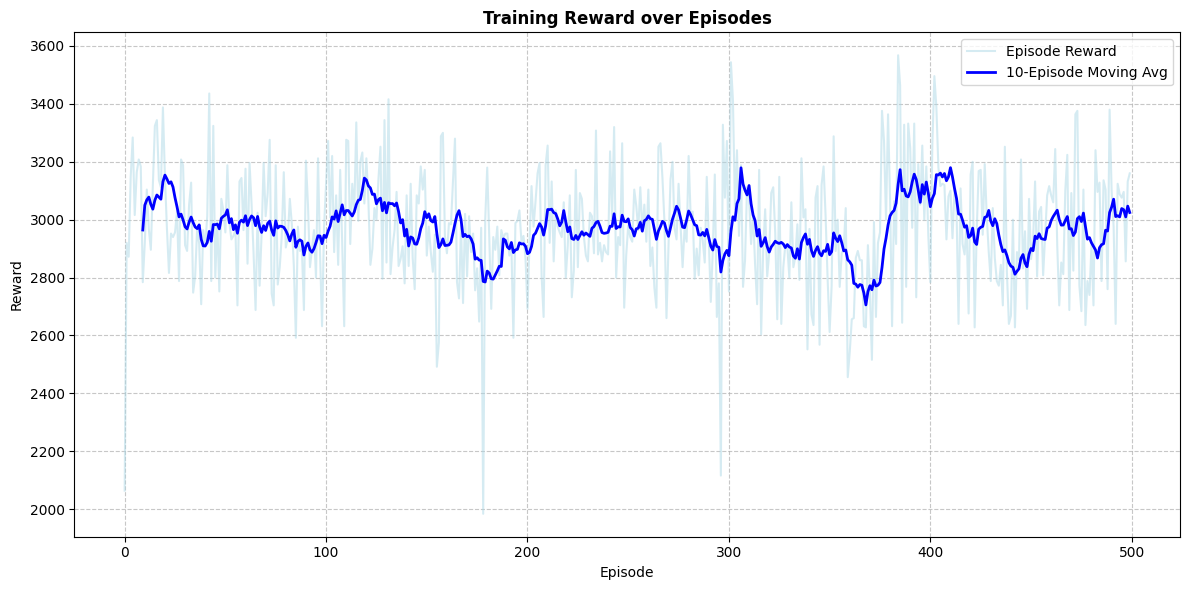

In [3]:
main()